In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

sns.set_theme(style='darkgrid')
colors = sns.color_palette('bright')

plt.rc('axes', titlesize=20) # fontsize of the axes title
plt.rc('axes', labelsize=18) # fontsize of the x and y labels
plt.rc('xtick', labelsize=16) # fontsize of the tick labels
plt.rc('ytick', labelsize=16) # fontsize of the tick labels
plt.rc('legend', fontsize=18) # legend fontsize
plt.rc('font', size=13) # controls default text sizes

plt.rcParams.update({'font.size': 15})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Importing plotly failed. Interactive plots will not work.


### Daily Temperature DF

In [2]:
daily_temp_df = pd.read_csv('data/daily-min-temperatures.csv')

In [3]:
daily_temp_df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
daily_temp_df.columns = ['date', 'temp']
daily_temp_df['date'] = pd.to_datetime(daily_temp_df['date'])

In [5]:
daily_temp_df.shape

(3650, 2)

In [6]:
daily_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3650 non-null   datetime64[ns]
 1   temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [7]:
daily_temp_df.describe()

,temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


(array([ 53., 181., 564., 862., 830., 670., 347., 102.,  32.,   9.]),
 array([ 0.  ,  2.63,  5.26,  7.89, 10.52, 13.15, 15.78, 18.41, 21.04,
        23.67, 26.3 ]),
 <BarContainer object of 10 artists>)

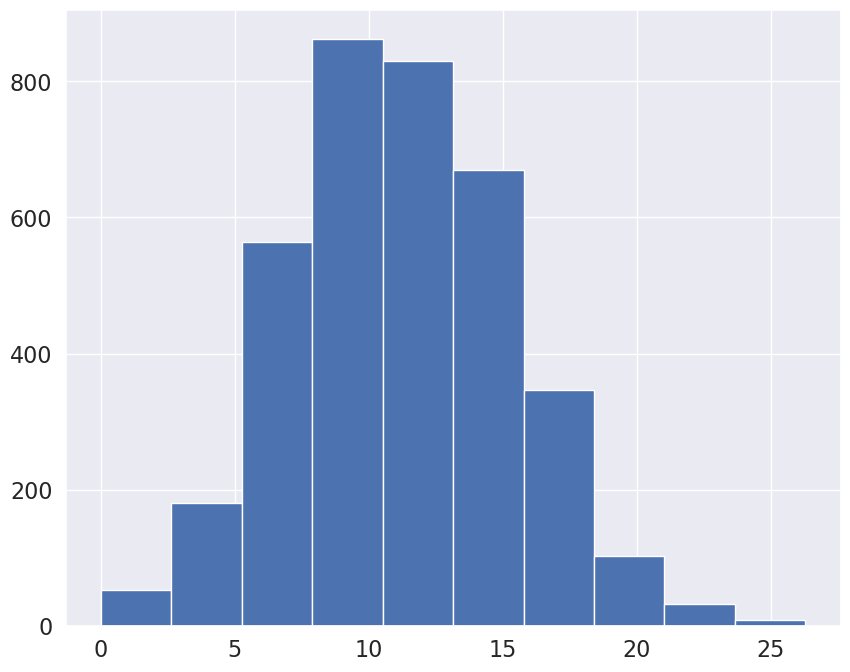

In [8]:
plt.rcParams['figure.figsize']=[10,8]
plt.hist(daily_temp_df['temp'])

In [9]:
mean_val = daily_temp_df['temp'].mean()
std_val = daily_temp_df['temp'].std()

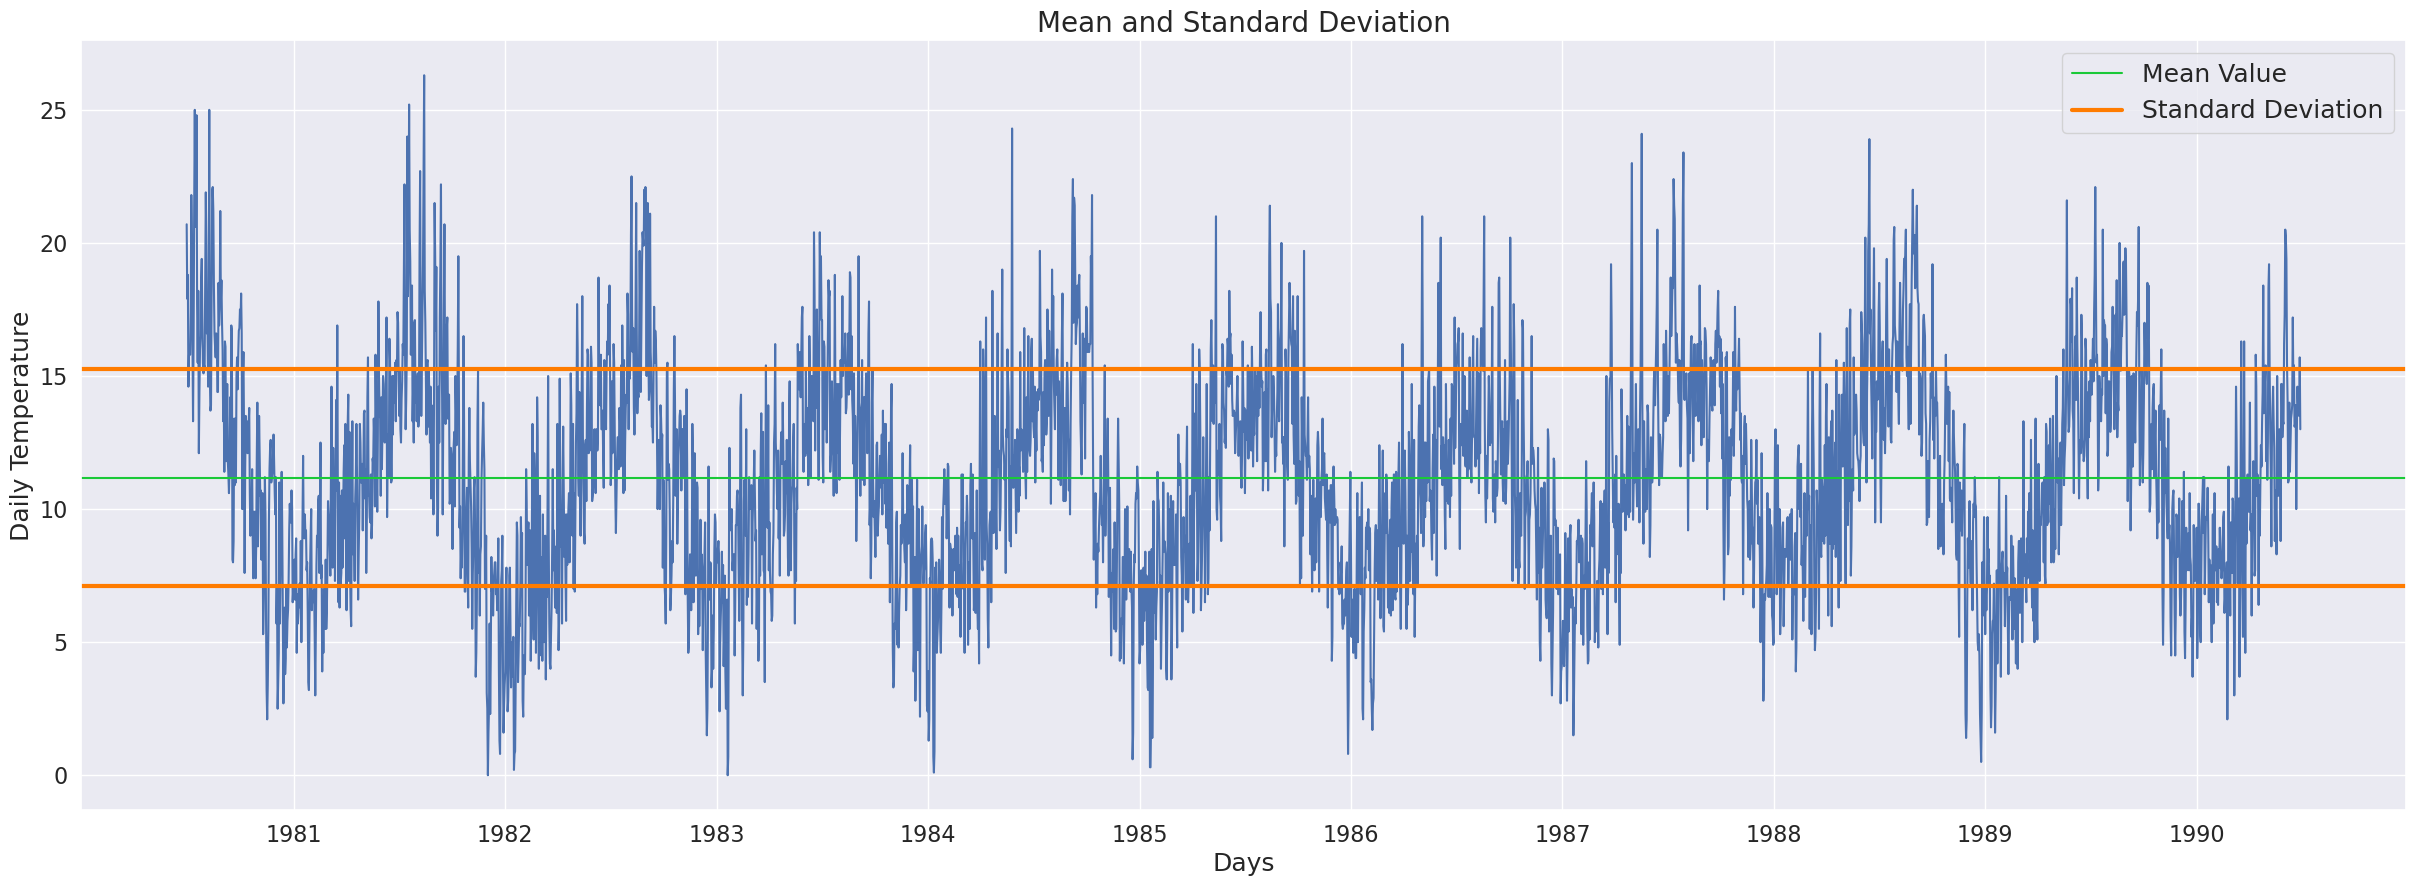

In [10]:
plt.rcParams['figure.figsize']=[30,10]

plt.plot(daily_temp_df['temp'])
plt.axhline(y=mean_val, color=colors[2], label='Mean Value')
plt.axhline(y=mean_val+std_val, color=colors[1], linewidth=3, label='Standard Deviation')
plt.axhline(y=mean_val-std_val, color=colors[1], linewidth=3)
plt.xticks(range(185, 3650, 365), daily_temp_df['date'].dt.year[range(185, 3650, 365)])
plt.xlabel('Days')
plt.ylabel('Daily Temperature')
plt.title('Mean and Standard Deviation')
plt.legend(loc='best')
plt.show()

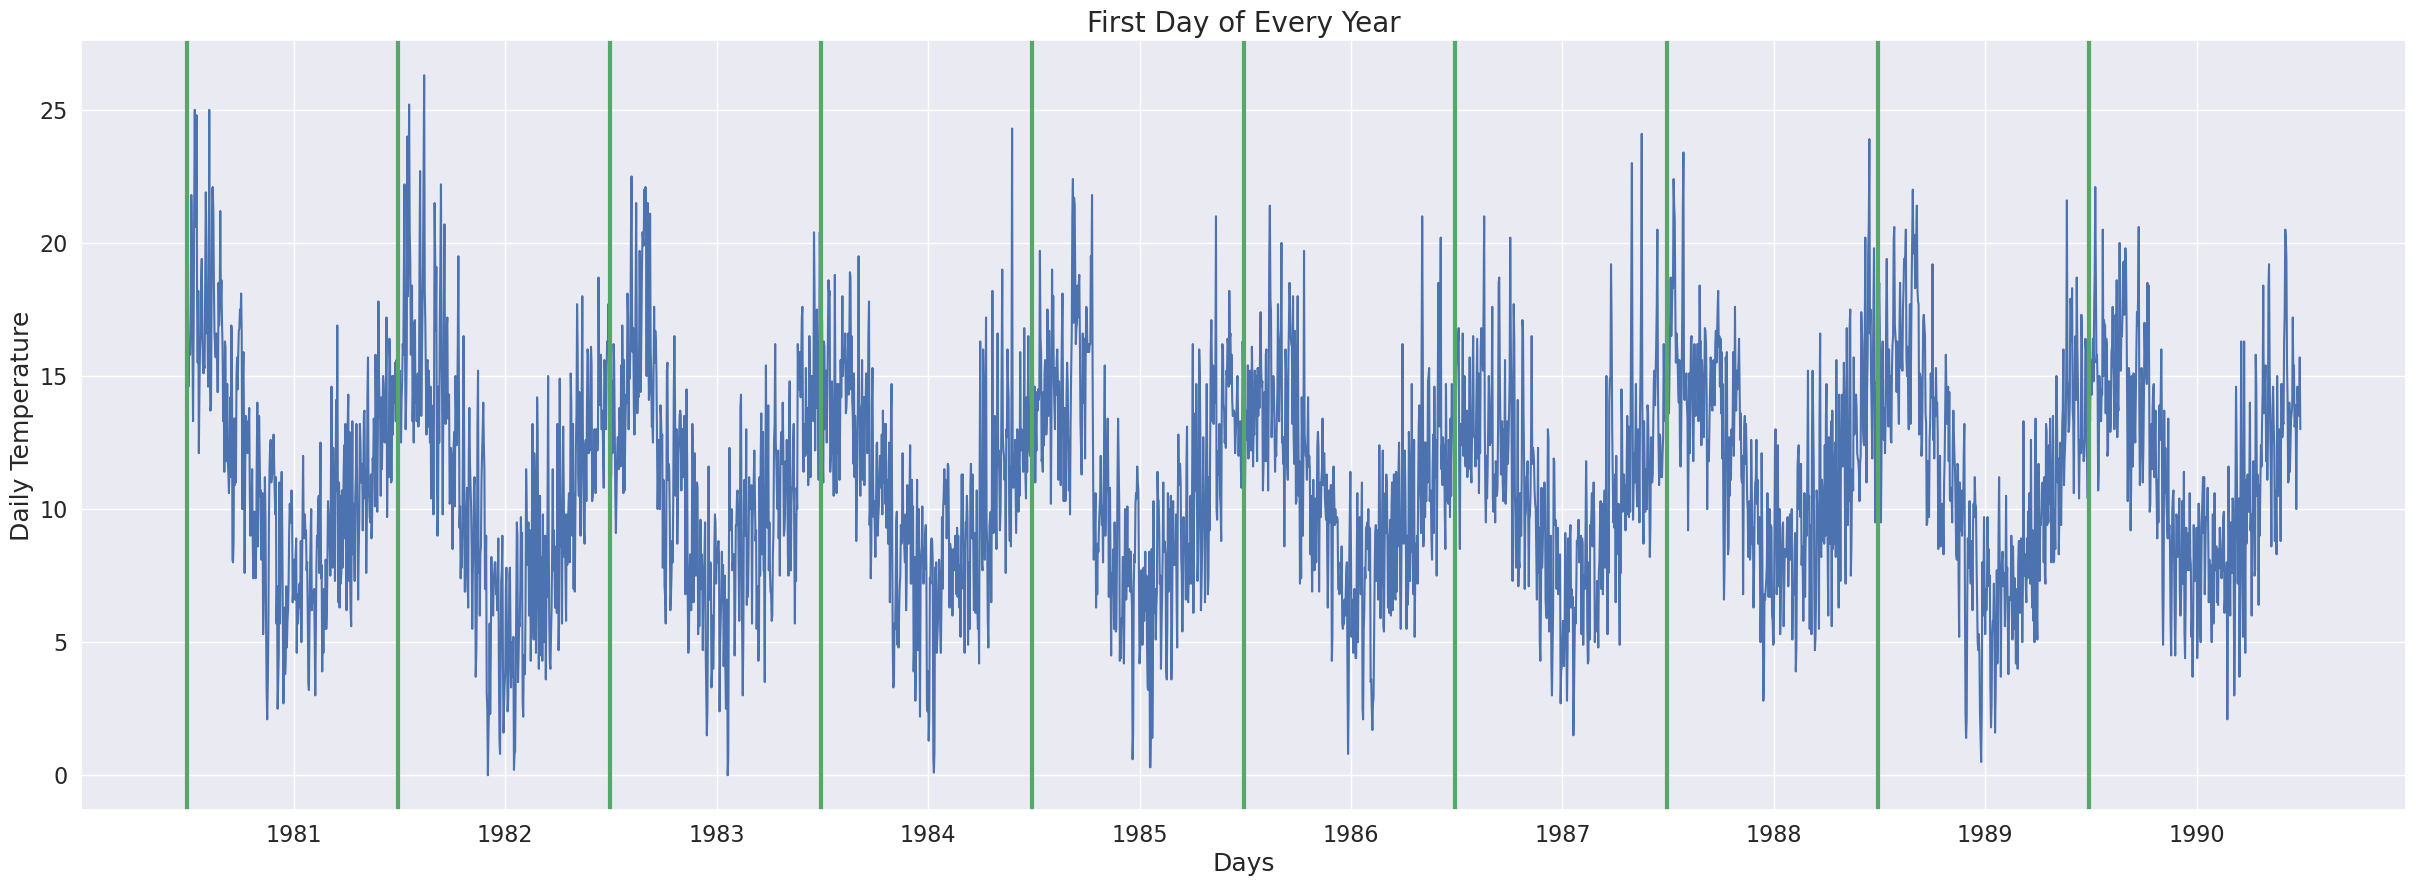

In [11]:
plt.rcParams['figure.figsize']=[30,10]

# fist day of every year
years_first_days = daily_temp_df.loc[((daily_temp_df['date'].dt.month == 1) & (daily_temp_df['date'].dt.day == 1))].index

plt.plot(daily_temp_df['temp'])
[plt.axvline(year, linewidth=3, color='g') for year in years_first_days]
plt.xticks(range(185, 3650, 365), daily_temp_df['date'].dt.year[range(185, 3650, 365)])
plt.xlabel('Days')
plt.ylabel('Daily Temperature')
plt.title('First Day of Every Year')
plt.show()

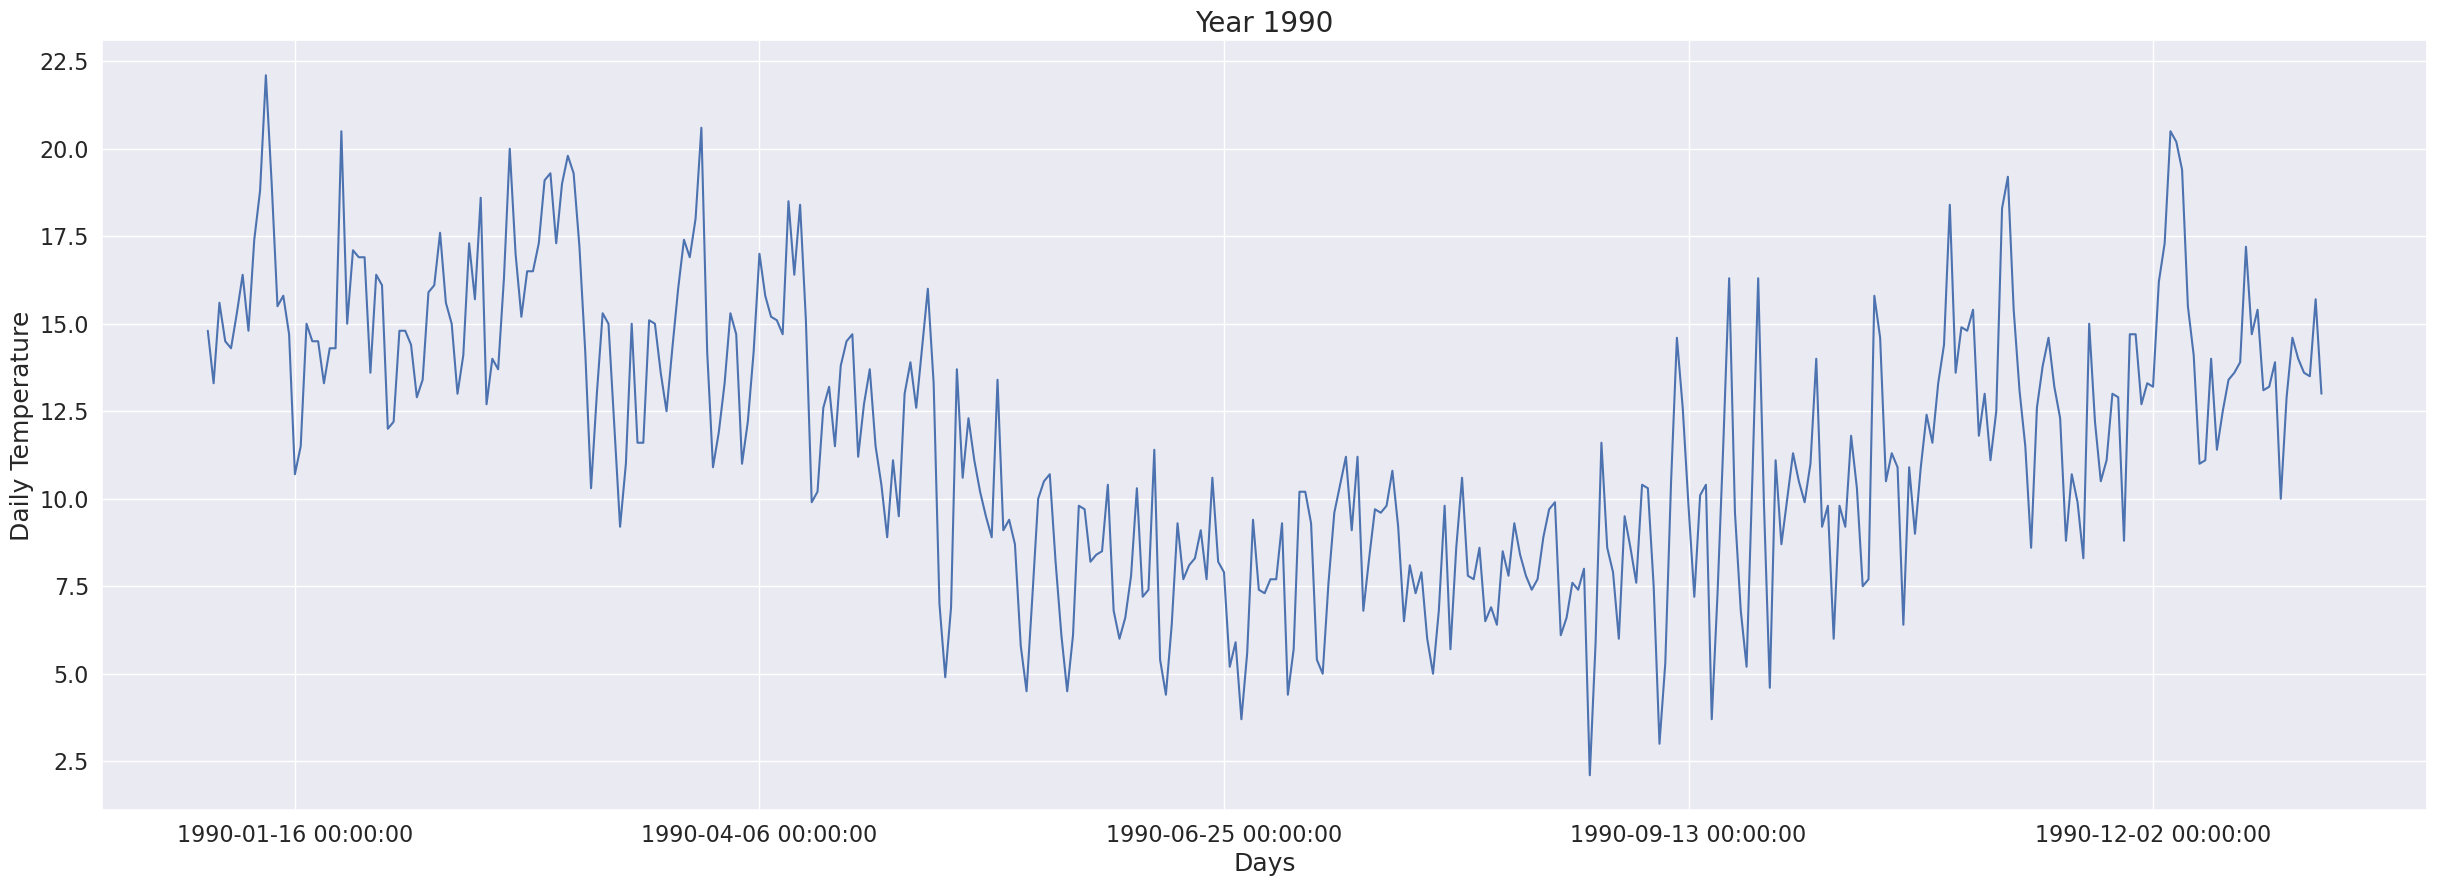

In [12]:
# Last Year (1990)
first_day_1990 = years_first_days[-1]

plt.plot(daily_temp_df['temp'][first_day_1990:])
plt.xticks(range(3300, 3650, 80), daily_temp_df['date'][range(3300, 3650, 80)])
plt.xlabel('Days')
plt.ylabel('Daily Temperature')
plt.title('Year 1990')
plt.show()

### Autocorrelation and Partial Autocorrelation

In [13]:
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

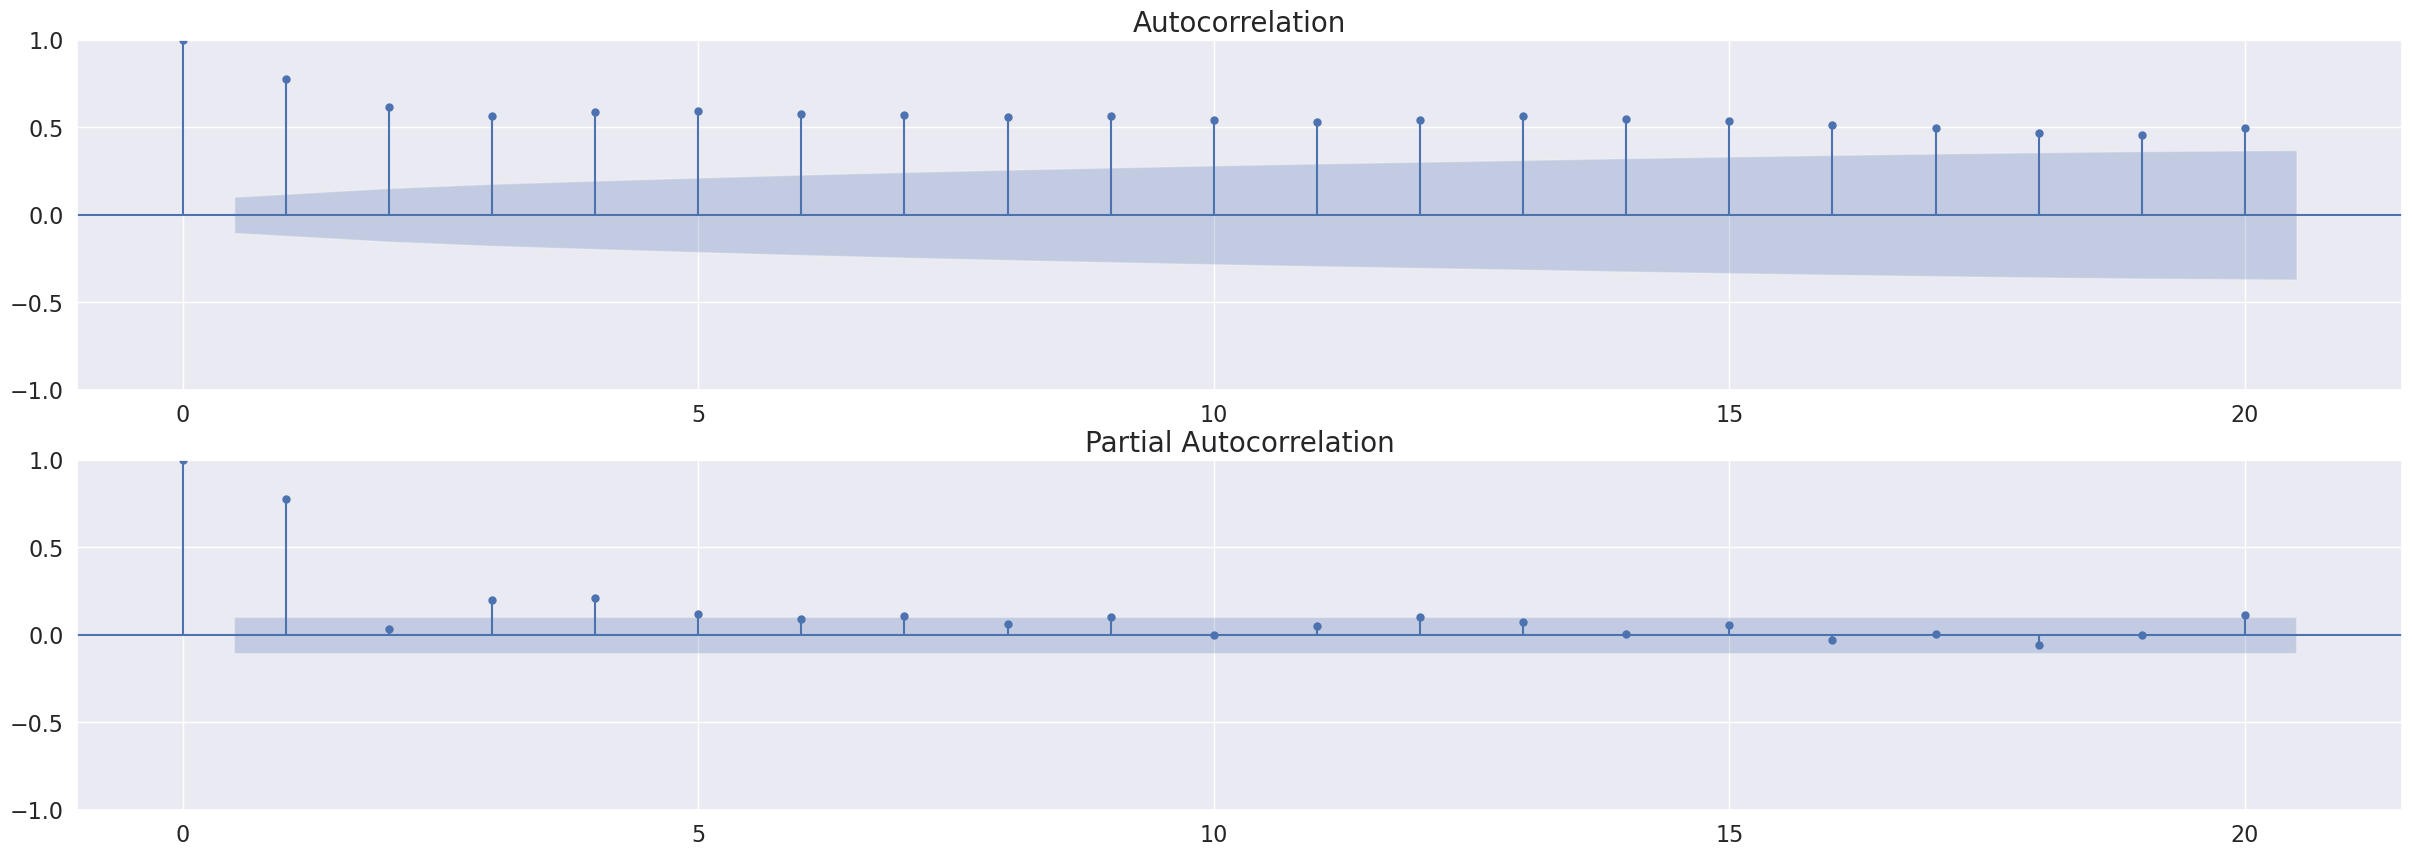

In [14]:
plt.figure()
plt.subplot(211)
plot_acf(daily_temp_df['temp'][first_day_1990:], lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(daily_temp_df['temp'][first_day_1990:], method='ywmle', lags=20, ax=plt.gca())
plt.show()

### FB Prophet

In [15]:
daily_temp_df_2 = daily_temp_df.copy()
daily_temp_df_2 = daily_temp_df_2[:first_day_1990]

daily_temp_df_2.columns = ['ds', 'y']

In [16]:
horizon = daily_temp_df.shape[0] - first_day_1990

In [17]:
model_prophet = Prophet(growth='linear',
                        changepoint_range=0.8,
                        n_changepoints=25,
                        seasonality_mode = 'multiplicative',
                        yearly_seasonality=True,
                        weekly_seasonality=True,
                        daily_seasonality=False,
                        seasonality_prior_scale=12,
                        changepoint_prior_scale=0.5,
                        interval_width=0.8)

model_prophet.fit(daily_temp_df_2)

19:32:26 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
forecast = model_prophet.make_future_dataframe(periods=horizon)
forecast.tail()

,ds
3645,1990-12-27
3646,1990-12-28
3647,1990-12-29
3648,1990-12-30
3649,1990-12-31


In [19]:
prediction = model_prophet.predict(forecast)

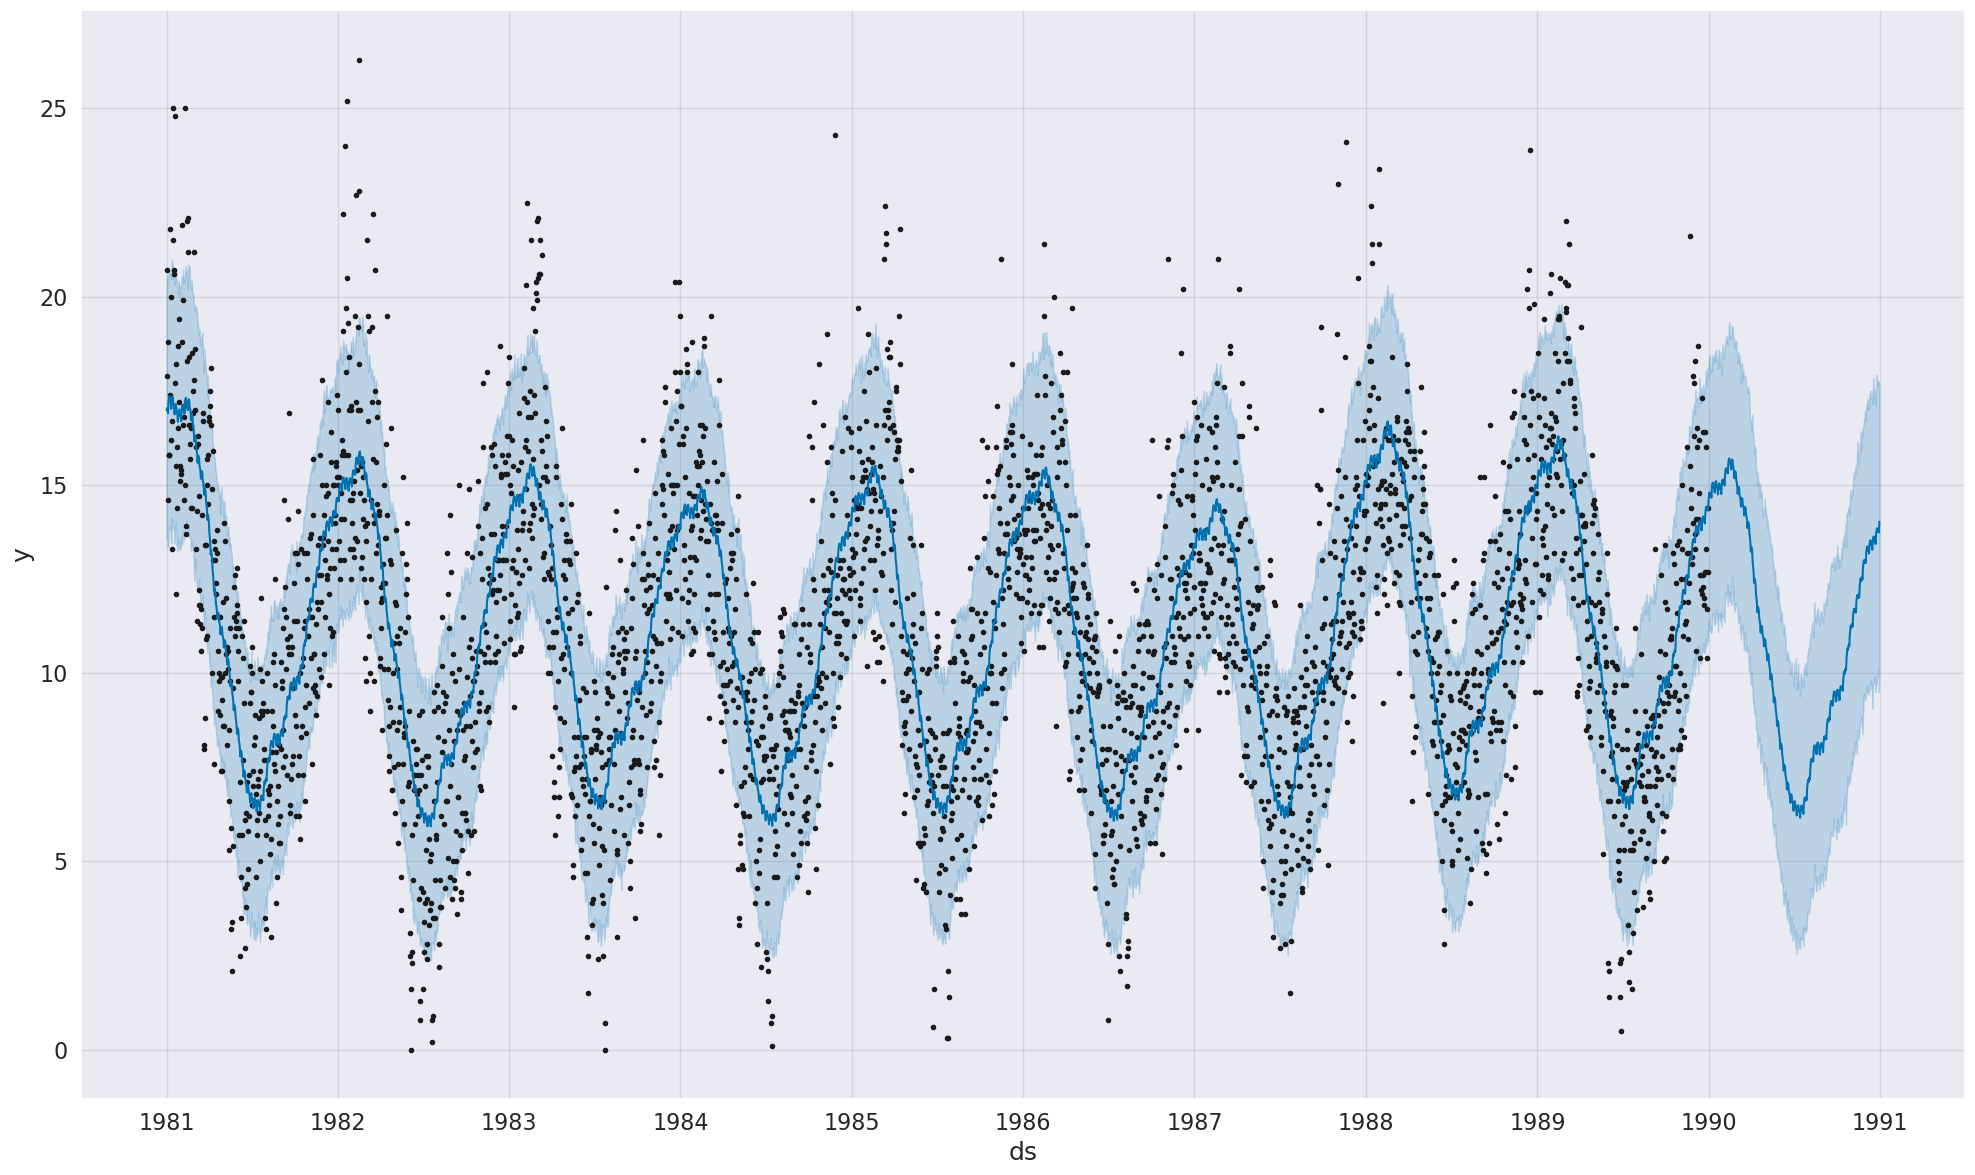

In [20]:
plt.rcParams['figure.figsize']=[30,10]
fig_1 = model_prophet.plot(prediction, figsize=(20, 12))

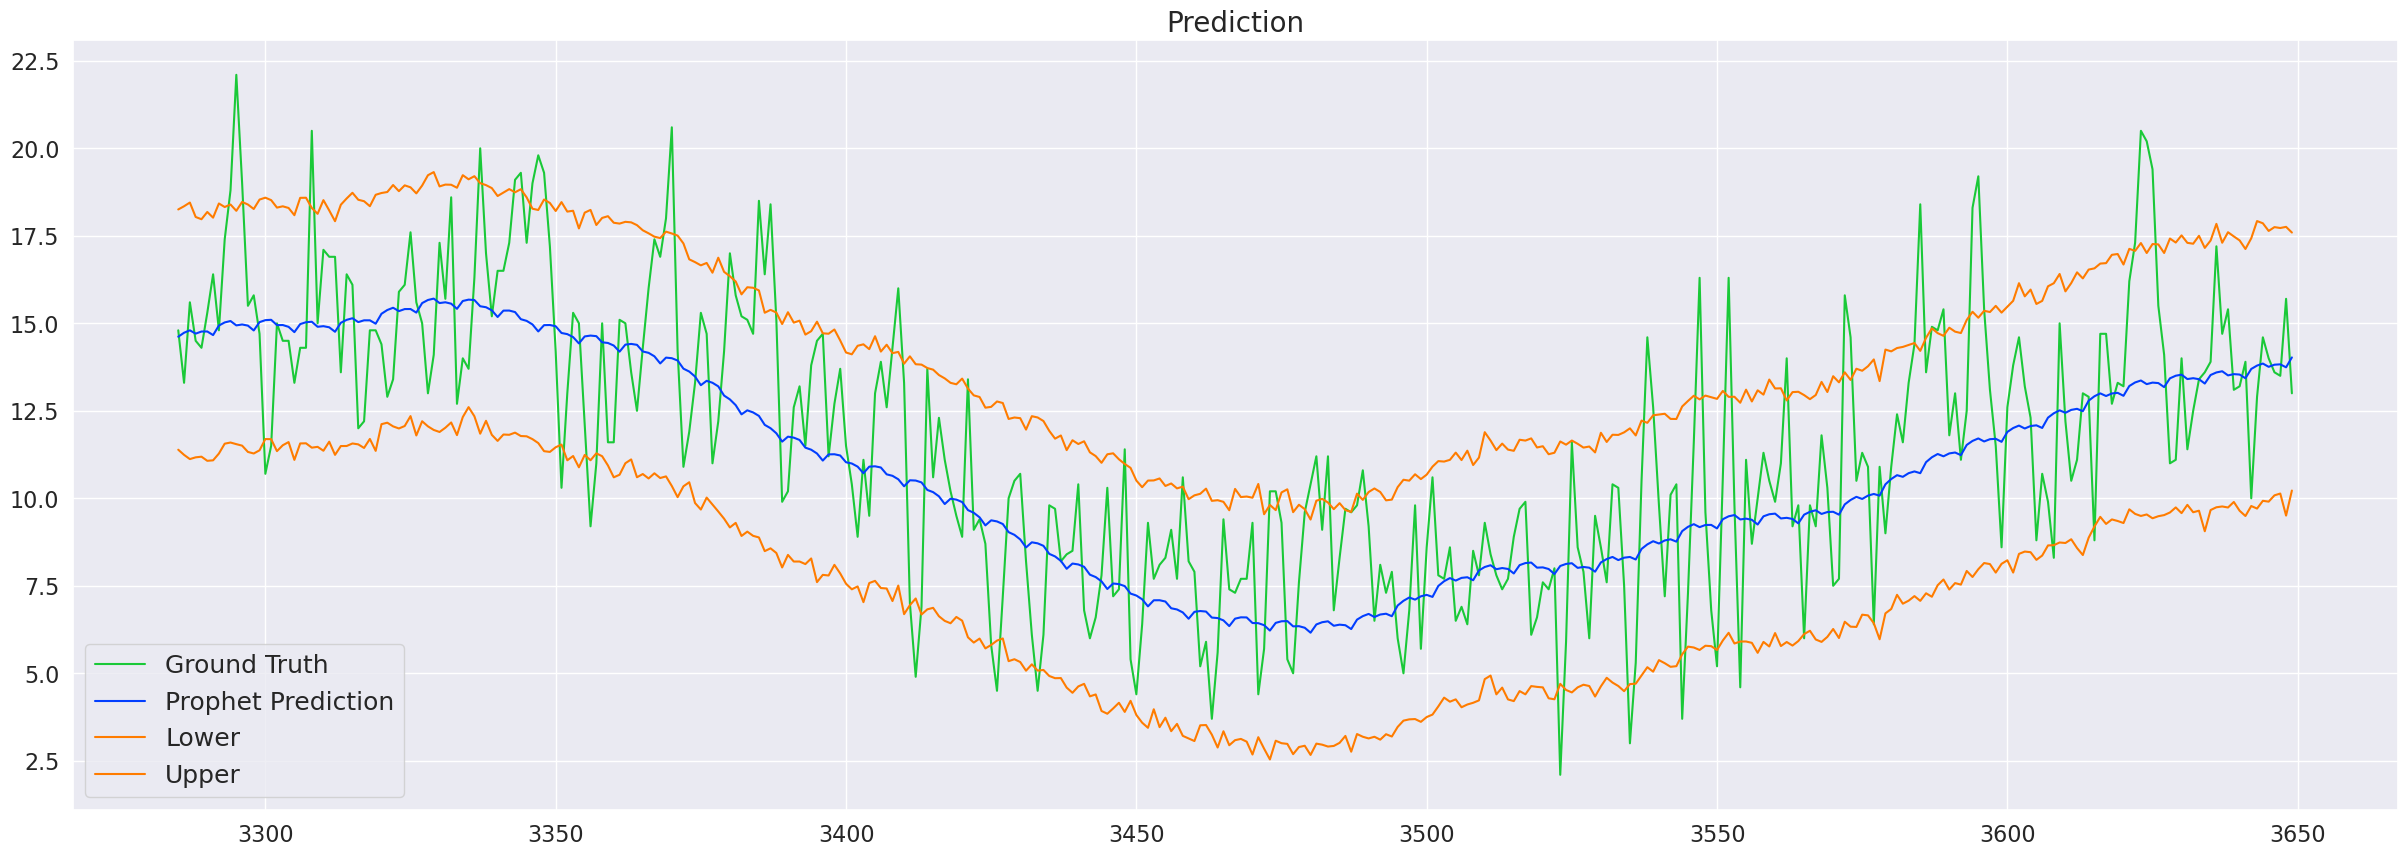

In [21]:
# Plot Real Data and Predicition
plt.plot(daily_temp_df['temp'][first_day_1990:], color=colors[2], label='Ground Truth')
plt.plot(prediction['yhat'][first_day_1990:], color=colors[0], label='Prophet Prediction')
plt.plot(prediction['yhat_lower'][first_day_1990:], color=colors[1], label='Lower')
plt.plot(prediction['yhat_upper'][first_day_1990:], color=colors[1], label='Upper')
plt.title('Prediction')
plt.legend(loc='best')
plt.show()

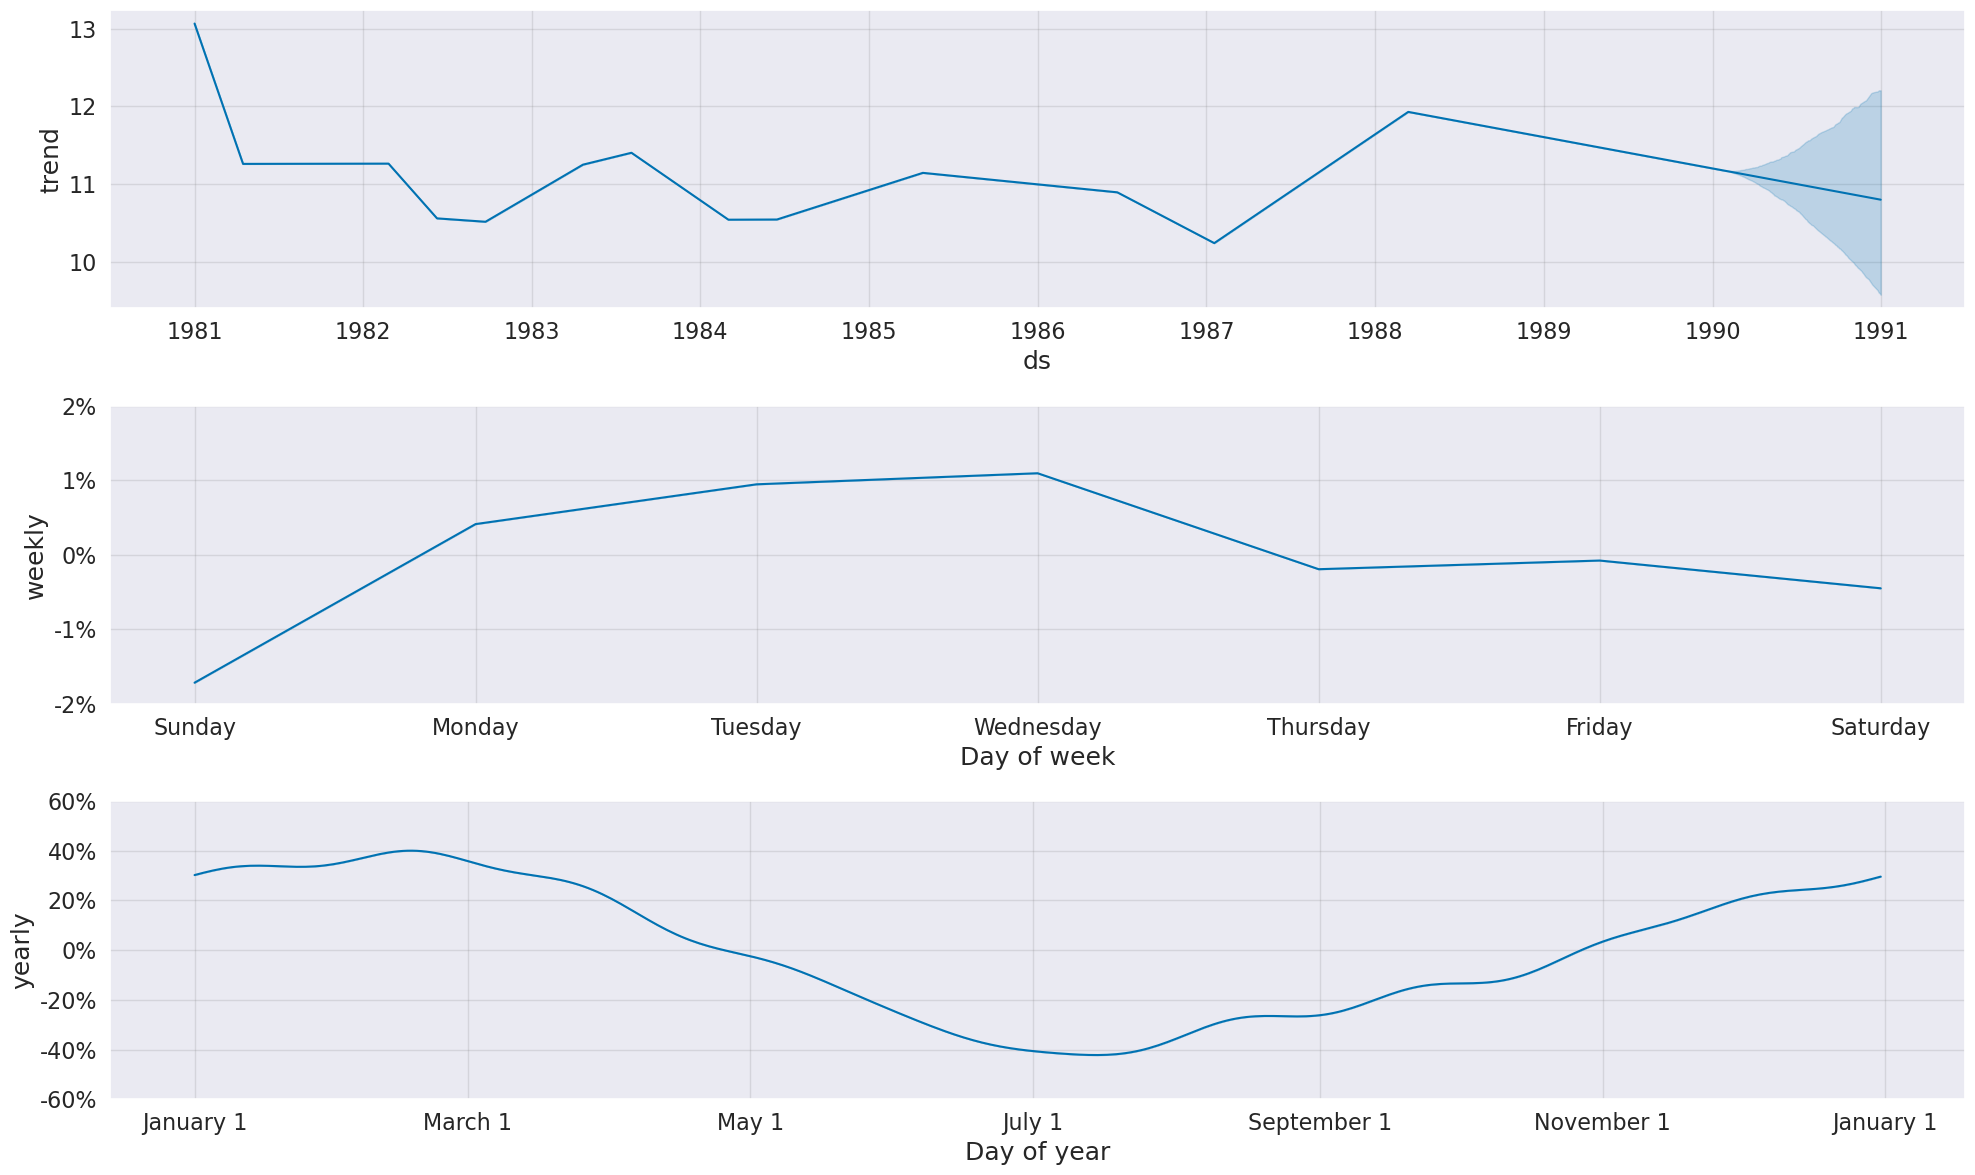

In [22]:
fig_2 = model_prophet.plot_components(prediction, figsize=(20, 12))

### Check Model Performance

In [23]:
performance = pd.DataFrame()
performance['y_true'] = daily_temp_df['temp'][first_day_1990:]
performance['y_pred'] = prediction['yhat'][first_day_1990:]
performance['yhat_lower'] = prediction['yhat_lower'][first_day_1990:]
performance['yhat_upper'] = prediction['yhat_upper'][first_day_1990:]
# Check MAE value
performance_MAE = mean_absolute_error(performance['y_true'], performance['y_pred'])
print(f'The MAE for the model is {performance_MAE}')
# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y_true'], performance['y_pred'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 1.99362163606021
The MAPE for the model is 0.1958678617304832


In [24]:
performance['error'] = performance['y_true'] - performance['y_pred']
performance['uncertanity'] = performance['yhat_upper'] - performance['yhat_lower']

In [25]:
performance.head()

,y_true,y_pred,yhat_lower,yhat_upper,error,uncertanity
3285,14.8,14.616696,11.388504,18.252955,0.183304,6.864452
3286,13.3,14.730402,11.240913,18.344742,-1.430402,7.103829
3287,15.6,14.799333,11.120373,18.450243,0.800667,7.329870
3288,14.5,14.705168,11.170475,18.037586,-0.205168,6.867112
3289,14.3,14.765056,11.189255,17.973531,-0.465056,6.784276


### Anomaly Detection

In [26]:
performance['anomaly'] = performance.apply(lambda x: 'Yes' if(np.abs(x['error'] > 1.5*x['uncertanity'])) else 'No', axis=1)

In [27]:
performance['anomaly'].value_counts()

No    365
Name: anomaly, dtype: int64

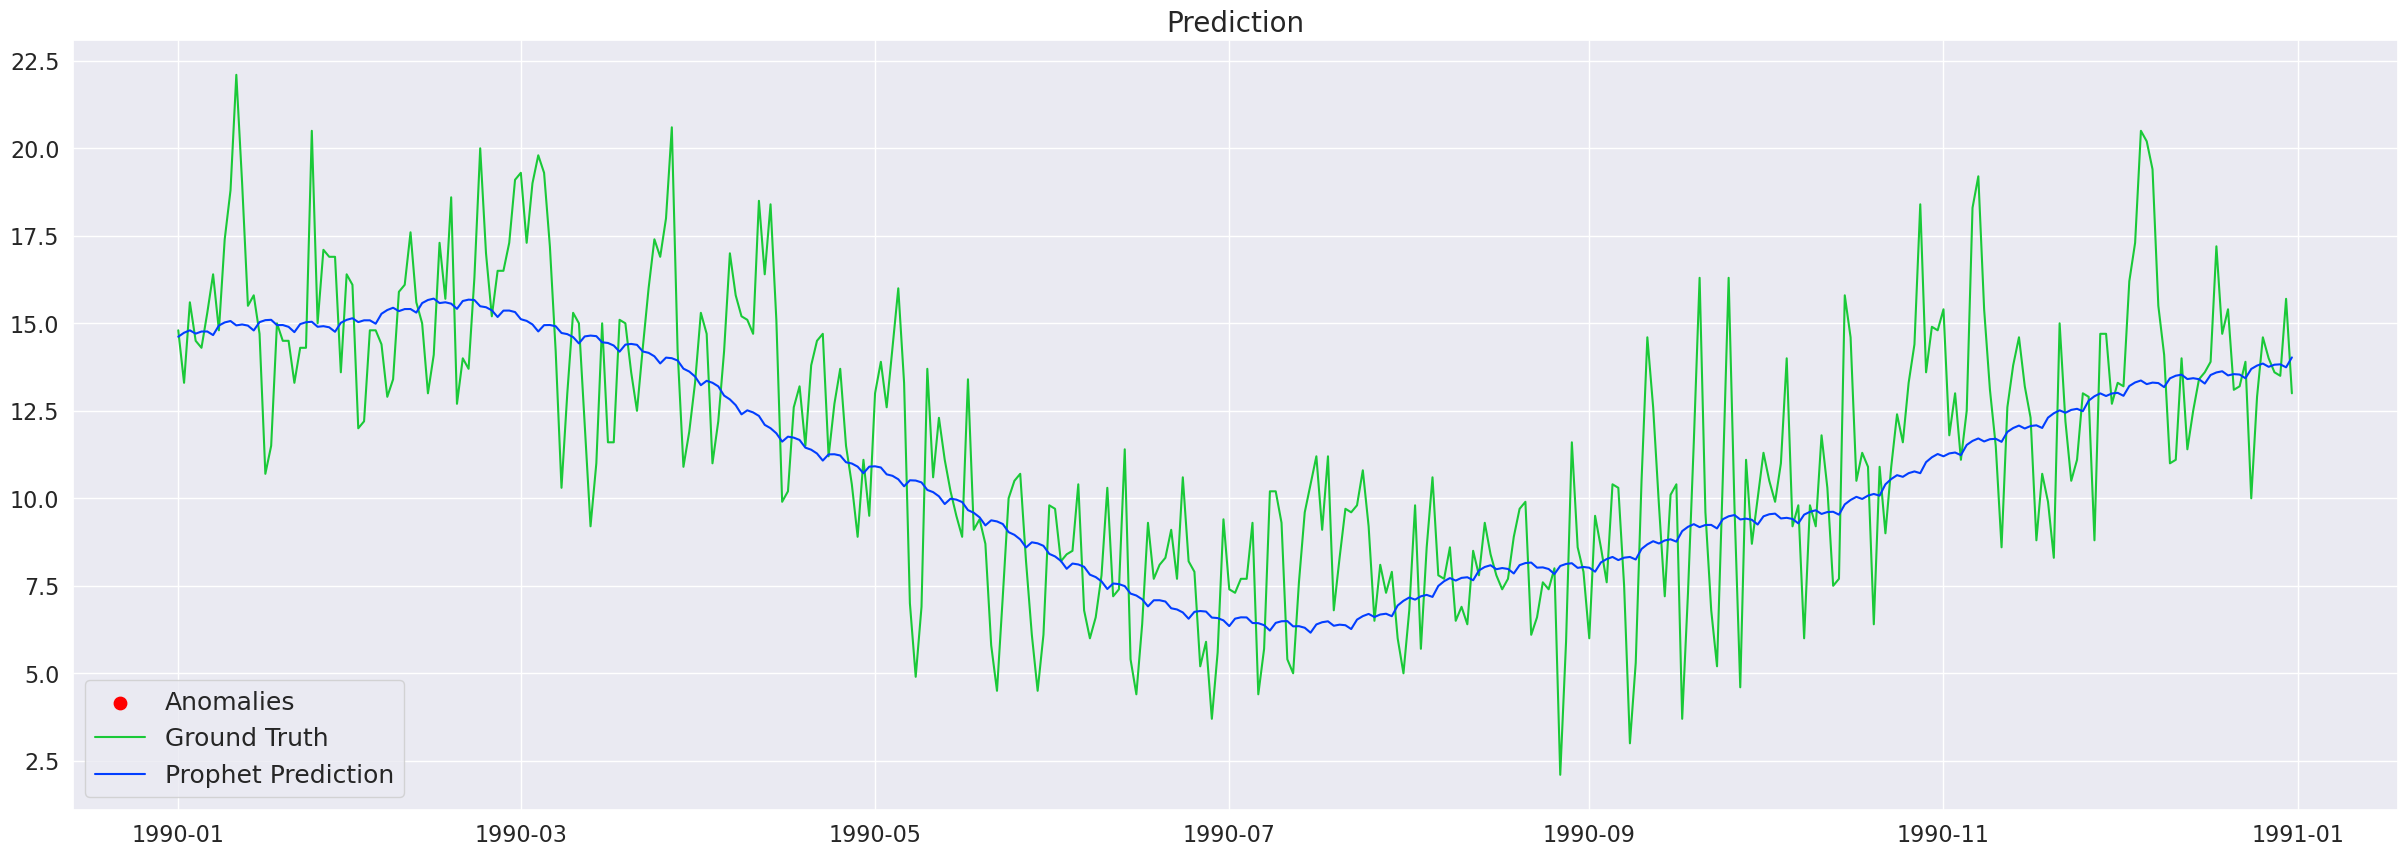

In [29]:
mask = performance['anomaly'] == 'Yes'

plt.scatter(daily_temp_df['date'][first_day_1990:][mask], performance['y_true'][mask], color='red', s=80, marker='o', label='Anomalies')
plt.plot(daily_temp_df['date'][first_day_1990:], daily_temp_df['temp'][first_day_1990:], color=colors[2], label='Ground Truth')
plt.plot(daily_temp_df['date'][first_day_1990:], performance['y_pred'], color=colors[0], label='Prophet Prediction')
plt.title('Prediction')
plt.legend(loc='best')
plt.show()